## Classificador ternário para características morfométricas de núcleo/citoplasma de células cervicais 

Classificador: Normal vs ASC-US, LSIL vs ASC-H, HSIL, Carc

In [52]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn import feature_selection as fs

from itertools import cycle

from random import randint
from random import sample

import xgboost as xgb 

import csv

In [53]:
IMG_W = 1376
IMG_H = 1020
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 
PATH_masks = "D:/baseCRIC/SegmentacaoCriC/mascaras" 

### Funções para extração de features - shape e contorno:

##### Gera dataframe de features: 120 features de formato e contorno para nucleo (N) e citoplasma (C)


In [54]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

In [55]:
# Filtra/normaliza dados
def normalize_dataset(df):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,38)]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
    
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,38)]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
 
  return dataset

### Funções para classificadores e métricas

In [56]:
# Executa e retorna a predição do modelo KNN:
def execute_KNN(data_train, target_train, data_test, n_nbors):     
        model_knn = KNeighborsClassifier(n_neighbors= n_nbors)      ## instancia
        model_knn.fit(data_train, target_train)                     ## treino 
        target_prediction = model_knn.predict(data_test)            ## teste  
        return target_prediction
    
# Executa e retorna a predição para SVM:
def execute_SVM(data_train, target_train, data_test, kn='rbf', degr=3):     
        model_svm = SVC(kernel= kn, degree=degr) 
        model_svm.fit(data_train, target_train)
        target_pred = model_svm.predict(data_test)
        return target_pred
    
# Executa e retorna a predição para Naive:
def execute_NB(data_train, target_train, data_test): 
       model_nb = GaussianNB()
       model_nb.fit(data_train, target_train)
       return model_nb.predict(data_test)
              
# Gera modelo RandomForest
def fit_get_RF(data_train, target_train): 
    model =RandomForestClassifier()
    model.fit(data_train, target_train)
    return model

def getModel(classifier = 'SVM', class_type = 'binary'):
    if classifier == 'SVM':
        model = SVC(kernel= 'rbf', degree=3, probability=True) 
    elif classifier == 'RF':
        model =RandomForestClassifier()
    elif classifier == 'XGBoost':
        if class_type == 'binary':
           #model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
           model = xgb.XGBClassifier(
                     learning_rate =0.25,
                     n_estimators=500,
                     max_depth=7,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     reg_alpha=0.05,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     seed=27)
        else:    # multiclass  
            #model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
            model = xgb.XGBClassifier(
                     learning_rate= 0.25,
                     n_estimators=500,
                     max_depth=7,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.9,
                     reg_alpha=0.05,
                     objective= 'multi:softprob',
                     seed=27)
    else:
        model = None # 'MLP toDo'    
    return model    
    

# Calcula métricas: (vide metrics_type e classifiers_type)
def calc_metric(target_test, target_predict, metric_type='acc', class_type ='binary', classes=[0,1,2]):   
    if (metric_type == 'acc'):
        return accuracy_score(target_test, target_predict)
    elif (metric_type == 'prec'):
         if (class_type == 'binary'):  ## caso classificadores binário
            return  precision_score(target_test, target_predict)  
         else:  ## multiclasses
            return precision_score(target_test, target_predict, average='weighted')
    elif (metric_type == 'rec'):
        if (class_type == 'binary'):  ## classificadores binários
            return recall_score(target_test, target_predict)
        else:  ## multiclasses
            return  recall_score(target_test, target_predict, average ='weighted')
    elif (metric_type == 'spec'):   
         if (class_type == 'binary'):  ## classificadores binários
            tn, fp, fn, tp = confusion_matrix(target_test, target_predict).ravel()
            return tn/(tn + fp)
         else:  ##  multiclasses - média aritmética  
            spec = 0
            for l in classes:
                tn, fp, fn, tp = confusion_matrix((np.array(target_test)==l), (np.array(target_predict)==l)).ravel()
                spec += tn/(tn + fp)
            return spec/len(classes)  
    elif (metric_type == 'f1_score'):      
         if (class_type == 'binary'):  ## classificadores binários
            f1 = f1_score(target_test, target_predict)
            return f1
         else:  ## multiclasses
            f1 = f1_score(target_test, target_predict, average= 'weighted')
            return f1 
    else:
        return None

def fill_line_metrics(model_name, featur, target, pred, line_results, class_type='binary', pos_lb=1):
    accur = calc_metric(target, pred, 'acc', class_type)
    prec = calc_metric(target, pred, 'prec', class_type, pos_lbl= pos_lb)
    sens = calc_metric(target, pred, 'sens', class_type)
    espe = calc_metric(target, pred, 'espec', class_type)
    f1Mes = calc_metric(target, pred, 'f1_mesure', class_type, pos_lbl= pos_lb)

    line = pd.Series(data = np.array([class_type, model_name, featur,
                        '{:.4f}'.format(accur), '{:.4f}'.format(prec), '{:.4f}'.format(sens),
                        '{:.4f}'.format((1- espe)), '{:.4f}'.format(espe), '{:.4f}'.format(f1Mes)], dtype = object), 
                index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line

def fill_line_metrics_CV(model_name, featur, line_results, metrics, results, class_type='binary'):
    line = pd.Series(data = np.array([class_type, model_name, featur,
             '{:.4f}'.format(metrics['acc']), '{:.4f}'.format(metrics['prec']),
             '{:.4f}'.format(metrics['rec']),'{:.4f}'.format((1- metrics['spec'])), 
             '{:.4f}'.format(metrics['spec']), '{:.4f}'.format(metrics['f1_score'])], dtype = object), 
              index=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 
                     'Falso Pos', 'Especif', 'F1_measure']) 
    results.loc[line_results] = line
    
    
def plot_roc_curve(roc_curve_list, labels_list):
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    for i,color in zip(range(len(roc_curve_list)), colors):
        plt.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            lw=2,
            label= labels_list[i],
        )
    plt.plot([0, 1] , c=".7", ls="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Normal vs anormal Random Forest) ')
    plt.legend(fontsize= 'medium')
    plt.show()
 

## Plota gráfico de ganho para features selecionadas: 
def plot_imp(best_features_1, scores_1, method_name_1,
            best_features_2, scores_2, method_name_2):   
    
    plt.style.use("bmh")
    #plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axs[0].tick_params(labelsize= 'small')
    axs[0].barh(best_features_1, scores_1, color= 'blue', height=0.75)    
    axs[0].set(xlim=[0,0.9], xlabel='Score', ylabel='Feature', title= method_name_1 + ' Scores')
    axs[1].tick_params(labelsize= 'small')
    axs[1].set(xlim=[0,0.2], xlabel='Score', ylabel='Feature', title=method_name_2 + ' Scores')
    axs[1].barh(best_features_2, scores_2, color= 'green')    
    
    #fig.suptitle('Feature Selection') 
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()

# Gera grafico matriz confusao  
def make_confusionMatrixDisplay(test, pred, labels, title):
    cm = confusion_matrix(test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return (disp, title)
 


In [57]:
def get_list_feature_labels():
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   efdNs = ['efdN'+str(i) for i in range(1,38)]  # 38 coefficientes da série Eliptica de fourier (vide EFD)  para borda N
   for name_f in efdNs:
       feature_labels.append(name_f) 
   
   aux=['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 
   for name_f in aux:
       feature_labels.append(name_f)
   efdCs = ['efdC'+str(i) for i in range(1,38)]  # 38 coefficientes da série Eliptica de fourier (vide EFD) para borda C

   for name_f in efdCs:
       feature_labels.append(name_f)
    
   aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']

   for name_f in aux:
       feature_labels.append(name_f)
   return feature_labels   



### Classificador Normal vs baixo grau (ASC-US,  LSIL) vs alto grau (ASC-H, HSIL, Carcinoma)

In [58]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = normalize_dataset(df)

In [59]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC33,efdC34,efdC35,efdC36,efdC37,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.558902,0.611302,0.230540,0.693720,0.589696,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.510303,0.523257,0.231571,0.685044,0.581329,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.478515,0.435149,0.153898,0.655169,0.522920,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.591569,0.584519,0.247649,0.751657,0.556125,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.572878,0.663556,0.193733,0.735400,0.579449,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.503038,0.510520,0.223721,0.668714,0.587139,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.489308,0.547526,0.208900,0.676792,0.582502,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.546541,0.650646,0.252706,0.720398,0.621497,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.495817,0.592085,0.168974,0.674437,0.569969,0.111823,0.078186,0.023058,3.177247,5.0


In [76]:
# Separa amostras por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


In [77]:
### FEATURES SELECTION: método Mutual Information
def features_selection(data_normal, data_ascus, data_lsil, data_asch, 
                       data_hsil,data_car, n_normal=154, n_ascus=77,
                       n_lsil=77, n_asch=51, n_hsil=51, n_car=52, 
                       N_FEATURES = 20):
    
    # Lista para filtro de FEATURES para o modelo:
    features = get_list_feature_labels() 
    
    aux = [0.0 for i in features]
    features_importances = dict(zip(features, aux))
    #Repete seleção com novo sorteio de dados
    for i in list(range(30)):
        sorted_idx_Normal = sample(range(0, data_normal.shape[0]), n_normal)
        sorted_idx_Normal.sort()

        data =  pd.DataFrame(data=np.vstack([
                                  data_normal.loc[sorted_idx_Normal].values,
                                  data_ascus.loc[sample(range(0, data_ascus.shape[0]), n_ascus)].values,
                                  data_asch.loc[sample(range(0, data_asch.shape[0]), n_asch)].values,
                                  data_lsil.loc[sample(range(0, data_lsil.shape[0]), n_lsil)].values, 
                                  data_hsil.loc[sample(range(0, data_hsil.shape[0]), n_hsil)].values,
                                  data_car.loc[sample(range(0, data_car.shape[0]), n_car)].values]), 
                                 columns = data_car.columns)
        
        data_x = data[features].values
        #print(data_x[0])
        data_y = data['bethesda'].values
        for i in range(data_x.shape[0]):       
            if data_y[i] == 3:
                data_y[i] = 1
            elif (data_y[i] == 4 or data_y[i] == 5):
                data_y[i] = 2
                
        ## Feature Selection using Mutual Info  
        fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=N_FEATURES)
        fs_fit_mutual_info.fit_transform(data_x, data_y)

        # ordena extrai do maior score para o menor entre as n_features mais importantes
        fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:N_FEATURES] # extrai do maior score para o menor entre as 10 features mais importantes
        best_features_mutual_info = data[features].columns[fs_indices_mutual_info].values
        feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
        #print(fs_fit_mutual_info.scores_)
        #contabiliza estatísticas:
        for feature, score in zip(best_features_mutual_info,              
                                  feature_importances_mutual_info):
            features_importances[feature] = (features_importances[feature] + score)
           # print(feature, score, features_importances[feature])
             
     
    features_importances_tuples = sorted(features_importances.items(), key=lambda item:item[1], reverse=True)
    best_features_mutual_info = []
    feature_importances_mutual_info = []
    for i in list(range(N_FEATURES)):
        best_features_mutual_info.append(features_importances_tuples[i][0])
        feature_importances_mutual_info.append(features_importances_tuples[i][1]/30)

    best_features_MI = np.asarray(best_features_mutual_info)
    feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
    return (best_features_MI, feature_importances_MI)

In [78]:
best_features_MI, feature_importances_MI = features_selection(data_normal, data_ascus, data_lsil, data_asch, 
                       data_hsil,data_car, n_normal=77, n_ascus=77,
                       n_lsil=77, n_asch=77, n_hsil=77, n_car=77, 
                       N_FEATURES = 20)


In [79]:
best_features_MI, feature_importances_MI

(array(['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'fdC', 'areaC',
        'equidiaC', 'minAxC', 'ardC', 'hAreaC', 'periC', 'eC', 'maxAxC',
        'mrdC', 'riC', 'compacC', 'circuC', 'periN', 'mrdN', 'ardN', 'eN'],
       dtype='<U14'),
 array([0.6240219 , 0.60418206, 0.6017845 , 0.5791013 , 0.5637324 ,
        0.5575426 , 0.50591356, 0.5046767 , 0.49896443, 0.49787506,
        0.48496643, 0.48301345, 0.48207107, 0.4757287 , 0.39797395,
        0.3962227 , 0.24734738, 0.20165752, 0.16936274, 0.16731639],
       dtype=float32))

### Separa amostras para classificação Ternária:
##### Classes: 0-normal,  1- ASC-Us + LSIL,  3-  ASC-H + HSIL + Car

In [80]:
N_CLASSES = 3

sorted_index = sample(range(0, data_normal.shape[0]), (154))

data_cl0  = pd.DataFrame(data=data_normal.loc[sorted_index].values, columns = df.columns)
 
data_cl1 =  pd.DataFrame(data=np.vstack([
                         data_ascus.loc[sample(range(0, data_ascus.shape[0]), 77)].values,
                         data_lsil.loc[sample(range(0, data_lsil.shape[0]), 77)].values]), 
                         columns = df.columns)
                           
data_cl2 =  pd.DataFrame(data=np.vstack([
                           data_asch.loc[sample(range(0, data_asch.shape[0]), 51)].values,
                           data_hsil.loc[sample(range(0, data_hsil.shape[0]), 51)].values,
                           data_car.loc[sample(range(0, data_car.shape[0]), 52)].values]), 
                         columns = df.columns)              

In [81]:
features = ['image_id', 'cell_id'] 
for feature in best_features_MI:
    features.append(feature)

features_desc = 'Features selected by MI'
features, best_features_MI

(['image_id',
  'cell_id',
  'ratio_NC',
  'ratio_NC_per',
  'ratio_NC_hArea',
  'fdC',
  'areaC',
  'equidiaC',
  'minAxC',
  'ardC',
  'hAreaC',
  'periC',
  'eC',
  'maxAxC',
  'mrdC',
  'riC',
  'compacC',
  'circuC',
  'periN',
  'mrdN',
  'ardN',
  'eN'],
 array(['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'fdC', 'areaC',
        'equidiaC', 'minAxC', 'ardC', 'hAreaC', 'periC', 'eC', 'maxAxC',
        'mrdC', 'riC', 'compacC', 'circuC', 'periN', 'mrdN', 'ardN', 'eN'],
       dtype='<U14'))

In [82]:
data_x = np.concatenate([data_cl0[features].values, data_cl1[features].values, data_cl2[features].values], axis=0)
data_y = np.concatenate([data_cl0['bethesda'].values, data_cl1['bethesda'].values, data_cl2['bethesda'].values], axis=0)
# {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
for i in range(data_y.shape[0]):
    if data_y[i] == 3:
       data_y[i] = 1
    elif (data_y[i] == 4 or data_y[i] == 5):
        data_y[i] = 2
sortidx = sample(range(0, data_x.shape[0]), data_x.shape[0])
data_x = data_x[sortidx]
data_y = data_y[sortidx]
data_x.shape, data_y.shape, data_y
#data_x[0,0], data_x[0,1], data_x[0,2], data_x[0,2:], data_y[0], data_cl0.iloc[0] 


((462, 22),
 (462,),
 array([0., 2., 0., 0., 0., 2., 2., 2., 0., 2., 2., 0., 2., 0., 2., 0., 2.,
        0., 1., 0., 0., 2., 0., 2., 0., 2., 2., 0., 2., 1., 0., 2., 2., 2.,
        1., 2., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 2., 1., 1., 0., 2.,
        2., 2., 0., 1., 2., 2., 2., 2., 1., 0., 2., 1., 1., 0., 0., 0., 1.,
        0., 2., 0., 0., 0., 2., 2., 0., 1., 1., 0., 1., 2., 1., 2., 2., 0.,
        1., 2., 0., 0., 0., 0., 1., 2., 1., 0., 2., 0., 1., 1., 0., 1., 1.,
        0., 2., 2., 2., 2., 1., 0., 2., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 2., 2., 2., 1., 2., 1., 0., 1., 1., 0., 2., 0., 0.,
        2., 0., 1., 2., 1., 2., 2., 1., 0., 1., 2., 1., 2., 1., 2., 2., 0.,
        1., 2., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        2., 1., 2., 2., 0., 0., 1., 1., 2., 2., 1., 2., 0., 0., 2., 2., 1.,
        1., 2., 1., 0., 1., 0., 1., 0., 2., 1., 1., 1., 2., 1., 1., 1., 0.,
        2., 0., 1., 1., 2., 1., 2., 0., 2., 2., 1., 1., 1., 0., 1.,

In [42]:
## Feature Selection using Random Forest:
N_FEATURES = 20
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(data_x[:,2:], data_y)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:N_FEATURES]
best_features_rfi = df.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
best_features_rfi, feature_importances_rfi

(array(['cell_id', 'extentN', 'eccenN', 'periN', 'equidiaN', 'hAreaN',
        'image_id', 'compacN', 'areaN', 'minAxN', 'elonN', 'eN', 'maxAxN',
        'riN', 'solidN', 'convexN', 'kN', 'circuN', 'sdnrlN', 'raN'],
       dtype=object),
 array([0.11039517, 0.10883197, 0.0822308 , 0.07308989, 0.07070783,
        0.06960931, 0.05159177, 0.05145113, 0.04946954, 0.04686461,
        0.04181755, 0.04140116, 0.03933645, 0.03445016, 0.02657534,
        0.02259374, 0.02021314, 0.02011799, 0.01978661, 0.01946582]))

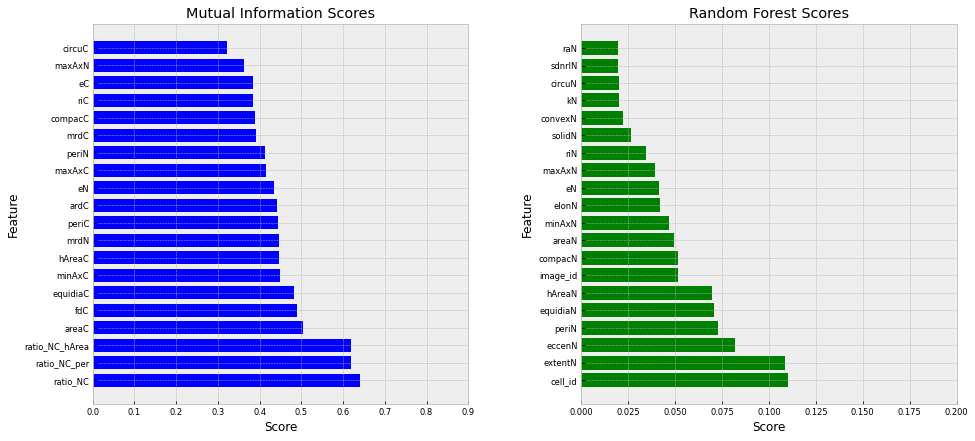

In [43]:
plot_imp(best_features_MI, feature_importances_MI, 'Mutual Information', 
         best_features_rfi, feature_importances_rfi, 'Random Forest')

### Cross-validation:  Normal vs ASC-US+LSIL vs ASC-H+HSIL+Car

In [83]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
lin= 0  ## linha inicial para inclusão no dataframe results
classifiers = ['SVM', 'RF', 'XGBoost']
ci = 0

In [86]:
# Se lected features
#features_selected = fs_indices_mutual_info  
features_desc= str(N_FEATURES)+" features selected by MI"  
N_SPLITS = 10 

# Executa cross-validation e mostra curvas ROC
cv = StratifiedKFold(n_splits= N_SPLITS)

accs = precs = recs = specs = f1_scores = aucs = np.zeros((N_SPLITS), dtype = np.float64)
tprs = []
mean_fpr = np.linspace(0, 1, 100)

preds_y = np.zeros_like(data_y)

## Ajusta features para treino e teste
X = data_x[:,2:]

model = getModel(classifier = classifiers[ci], class_type = 'multiclass')
for i, (train, test) in enumerate(cv.split(X, data_y)):
    # Ajusta modelo:
    model.fit(X[train], data_y[train])    
    
    # Predição:
    pred_y = model.predict(X[test])
    prob_y = model.predict_proba(X[test])
    
    #Registra predições:
    preds_y[test] = pred_y
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(data_y[test], pred_y, metric_type='acc', class_type = 'multiclass', classes=[0,1,2])
    precs[i] = calc_metric(data_y[test], pred_y, metric_type='prec', class_type = 'multiclass', classes=[0,1,2])                
    recs[i] = calc_metric(data_y[test], pred_y, metric_type='rec', class_type = 'multiclass', classes=[0,1,2])                
    specs[i] = calc_metric(data_y[test], pred_y, metric_type='spec', class_type = 'multiclass', classes=[0,1,2])                
    f1_scores[i] = calc_metric(data_y[test], pred_y, metric_type='f1_score', class_type = 'multiclass', classes=[0,1,2])                
                            
## Registra resultados (dataframe):
metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
           'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}      

fill_line_metrics_CV(classifiers[ci], features_desc, lin, metrics, results, class_type= "ternary")

# Acumula Matrizes de confusão:
conf_matrix_list.append(make_confusionMatrixDisplay(
      data_y, preds_y, labels = [0,1,2], title=features_desc + "- "+classifiers[ci]))

lin+= 1
ci+= 1                     

# Exibe curva ROC para classificador Binário (cross validation)
def plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - Normal vs Anormal"):
    fig, ax = plt.subplots(figsize=(9,5))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy", "darkorange"])
    plt.style.use("bmh")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    for i,color in zip(range(len(roc_curve_list)), colors):
        ax.plot(
            roc_curve_list[i][0],
            roc_curve_list[i][1],
            color=color,
            label=labels_list[i],
            lw=2,
            alpha=0.8,
        )
 
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title= title
    )
    ax.legend(loc="lower right")
    plt.show()

# Calcula e registra curva ROC média (CV)
    # Calcula curva_roc e AUC:
    #prob = prob_y[:, 1]
    #fpr, tpr, thresholds = roc_curve(data_y[test], prob)
    #interp_tpr = np.interp(mean_fpr, fpr, tpr)
    #interp_tpr[0] = 0.0
    #tprs.append(interp_tpr)
    #aucs[i]= auc(mean_fpr, interp_tpr)
#mean_tpr = np.mean(tprs, axis=0)
#mean_tpr[-1] = 1.0
#mean_auc = auc(mean_fpr, mean_tpr)
#std_auc = np.std(aucs)
#roc_curve_list.append((mean_fpr, mean_tpr))
#label = r"Mean ROC (AUC %s= %0.4f $\pm$ %0.4f)" % ((classifiers[ci]+"-ternary "), mean_auc, std_auc)
#labels_list.append(label)


In [87]:
len(labels_list), len(roc_curve_list), len(conf_matrix_list)

(0, 0, 3)

### Resultados:

In [88]:
#plot_roc_curve_CV(roc_curve_list, labels_list, title = "Normal vs ASC-US/LSIL vs ASC-H/HSIL/Car")
results


,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,20 features selected by MI,0.9121,0.9121,0.9121,0.0879,0.9121,0.9121
1,ternary,RF,20 features selected by MI,0.9216,0.9216,0.9216,0.0784,0.9216,0.9216
2,ternary,XGBoost,20 features selected by MI,0.9174,0.9174,0.9174,0.0826,0.9174,0.9174


#### Matrizes de confução

<Figure size 432x288 with 0 Axes>

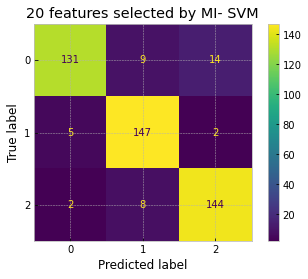

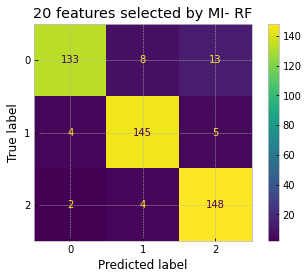

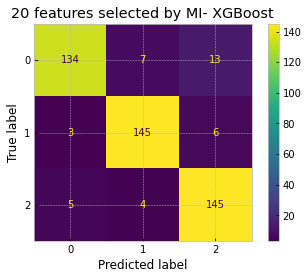

<Figure size 432x288 with 0 Axes>

In [89]:
#%matplotlib inline    

plt.figure(figsize=(6, 4))   #tupla para tamanho da figura (largura, altura)

for i in range(len(conf_matrix_list)):
    conf_matrix_list[i][0].plot()
    plt.title(conf_matrix_list[i][1])

plt.show()
plt.tight_layout()    #inclui espaçamento entre os gráficos